## Imports

In [130]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tqdm import tqdm  

In [131]:
CIFAR10.train_list

[['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
 ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
 ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
 ['data_batch_4', '634d18415352ddfa80567beed471001a'],
 ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb']]

## Data Loading and Preprocessing

In [132]:
# Set seed for reproducibility
torch.manual_seed(42)

# Define data transformations with augmentations for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define data transformations with normalization for validation/testing
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset without transformations for validation
cifar_dataset = CIFAR10(root='./data', train=True, download=True)

# Split dataset into train and validation sets
train_size = int(0.8 * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
train_dataset, val_dataset = random_split(cifar_dataset, [train_size, val_size])

# Apply transformations to training dataset
train_dataset.dataset.transform = transform_train

# Apply normalization to validation dataset
val_dataset.dataset.transform = transform_val

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified


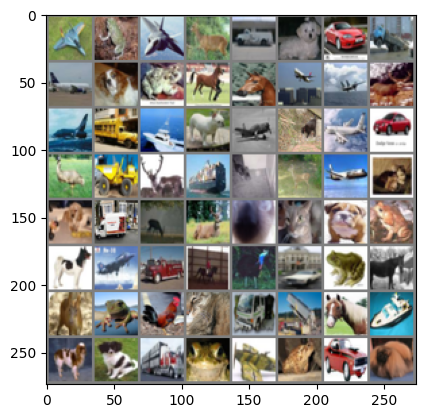

Labels: [0 6 0 4 9 5 1 9 0 5 6 7 7 0 0 4 0 9 8 5 0 3 0 1 2 9 4 8 3 4 0 3 5 9 4 4 3
 3 5 6 5 0 9 7 2 1 6 7 4 6 2 3 9 9 7 8 5 5 9 6 0 6 1 5]


In [133]:
# Get one batch of images from the DataLoader
images, labels = next(iter(train_loader))

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display a few images from the batch
imshow(make_grid(images))
print('Labels:', labels.numpy())

## Modeling
the model is inspired from VGG Arch but a small version with some modifications

In [150]:
class SimpleCNN(nn.Module):
    def __init__(self, first_dim=64):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, first_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(first_dim),  
            nn.ReLU(inplace=True),
            
            nn.Conv2d(first_dim, first_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(first_dim),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(first_dim, first_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(first_dim*2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(first_dim*2 * 8 * 8, first_dim*2),
            nn.BatchNorm1d(first_dim*2), 
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(first_dim*2, 10)  
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Optimization

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = SimpleCNN()
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

In [153]:
class EarlyStopper:
    '''Early stops the training if validation loss doesn't improve after a given patience.'''
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [154]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device="cuda"):
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total_train += labels.size(0)
                correct_train += predicted.eq(labels).sum().item()

                pbar.set_postfix({'Loss': total_loss / total_train, 'Accuracy': 100 * correct_train / total_train})

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_predicted = []
        all_labels = []

        with tqdm(val_loader, desc=f'Validation', leave=False) as pbar:
            with torch.no_grad():
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)
                    total_val_loss += val_loss.item()

                    _, predicted_val = outputs.max(1)
                    all_predicted.extend(predicted_val.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    total_val += labels.size(0)
                    correct_val += predicted_val.eq(labels).sum().item()

                    pbar.set_postfix({'Loss': total_val_loss / total_val, 'Accuracy': 100 * correct_val / total_val})

        # Compute metrics during training
        average_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Compute metrics during validation
        average_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_precision = precision_score(all_labels, all_predicted, average='weighted')
        val_recall = recall_score(all_labels, all_predicted, average='weighted')
        val_f1 = f1_score(all_labels, all_predicted, average='weighted')

        # Store metrics
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(average_val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

        print(f'Validation Precision: {val_precision:.4f}, '
              f'Validation Recall: {val_recall:.4f}, '
              f'Validation F1-Score: {val_f1:.4f}')

        if early_stopper.early_stop(average_val_loss):
            break

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1_scores': val_f1_scores,
    }


In [155]:
def plot_history(history):
    plt.figure(figsize=(18, 8))

    # Plot training and validation losses
    plt.subplot(2, 3, 1)
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(2, 3, 2)
    plt.plot(history['train_accuracies'], label='Training Accuracy')
    plt.plot(history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot validation precisions
    plt.subplot(2, 3, 3)
    plt.plot(history['val_precisions'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Plot validation recalls
    plt.subplot(2, 3, 4)
    plt.plot(history['val_recalls'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # Plot validation F1-scores
    plt.subplot(2, 3, 5)
    plt.plot(history['val_f1_scores'], label='Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [156]:
EPOCHS = 15

In [157]:
history1 = train_and_validate(model1, train_loader, val_loader, optimizer1, criterion, num_epochs=EPOCHS, device="cuda")

Epoch 1/15, Training Loss: 1.2978, Training Accuracy: 53.47%, Validation Loss: 0.9556, Validation Accuracy: 66.43
Validation Precision: 0.6670, Validation Recall: 0.6643, Validation F1-Score: 0.6626


Epoch 2/15, Training Loss: 0.9717, Training Accuracy: 65.72%, Validation Loss: 0.8712, Validation Accuracy: 68.83
Validation Precision: 0.6960, Validation Recall: 0.6883, Validation F1-Score: 0.6866


Epoch 3/15, Training Loss: 0.8352, Training Accuracy: 70.64%, Validation Loss: 0.7302, Validation Accuracy: 74.61
Validation Precision: 0.7453, Validation Recall: 0.7461, Validation F1-Score: 0.7445


Epoch 4/15, Training Loss: 0.7377, Training Accuracy: 74.00%, Validation Loss: 0.7498, Validation Accuracy: 73.20
Validation Precision: 0.7401, Validation Recall: 0.7320, Validation F1-Score: 0.7290


Epoch 5/15, Training Loss: 0.6550, Training Accuracy: 77.13%, Validation Loss: 0.6964, Validation Accuracy: 75.73
Validation Precision: 0.7603, Validation Recall: 0.7573, Validation F1-Score: 0.7545


Epoch 6/15, Training Loss: 0.5845, Training Accuracy: 79.71%, Validation Loss: 0.7521, Validation Accuracy: 73.88
Validation Precision: 0.7612, Validation Recall: 0.7388, Validation F1-Score: 0.7366


Epoch 7/15, Training Loss: 0.5201, Training Accuracy: 81.61%, Validation Loss: 0.6723, Validation Accuracy: 76.94
Validation Precision: 0.7661, Validation Recall: 0.7694, Validation F1-Score: 0.7667


Epoch 8/15, Training Loss: 0.4623, Training Accuracy: 83.84%, Validation Loss: 0.6935, Validation Accuracy: 76.52
Validation Precision: 0.7702, Validation Recall: 0.7652, Validation F1-Score: 0.7647


Epoch 9/15, Training Loss: 0.4102, Training Accuracy: 85.55%, Validation Loss: 0.7106, Validation Accuracy: 76.17
Validation Precision: 0.7684, Validation Recall: 0.7617, Validation F1-Score: 0.7610


Epoch 10/15, Training Loss: 0.3682, Training Accuracy: 87.03%, Validation Loss: 0.7211, Validation Accuracy: 76.52
Validation Precision: 0.7812, Validation Recall: 0.7652, Validation F1-Score: 0.7669


Epoch 11/15, Training Loss: 0.3258, Training Accuracy: 88.50%, Validation Loss: 0.7032, Validation Accuracy: 78.05
Validation Precision: 0.7816, Validation Recall: 0.7805, Validation F1-Score: 0.7803


Epoch 12/15, Training Loss: 0.2871, Training Accuracy: 89.98%, Validation Loss: 0.7582, Validation Accuracy: 75.98
Validation Precision: 0.7684, Validation Recall: 0.7598, Validation F1-Score: 0.7602


Epoch 13/15, Training Loss: 0.2538, Training Accuracy: 90.91%, Validation Loss: 0.7479, Validation Accuracy: 77.84
Validation Precision: 0.7806, Validation Recall: 0.7784, Validation F1-Score: 0.7776


Epoch 14/15, Training Loss: 0.2313, Training Accuracy: 91.92%, Validation Loss: 0.8048, Validation Accuracy: 77.02
Validation Precision: 0.7774, Validation Recall: 0.7702, Validation F1-Score: 0.7700


Epoch 15/15, Training Loss: 0.2090, Training Accuracy: 92.75%, Validation Loss: 0.7547, Validation Accuracy: 77.82
Validation Precision: 0.7832, Validation Recall: 0.7782, Validation F1-Score: 0.7793


The Acc of the validation is kinda low + there's an obvious overfitting

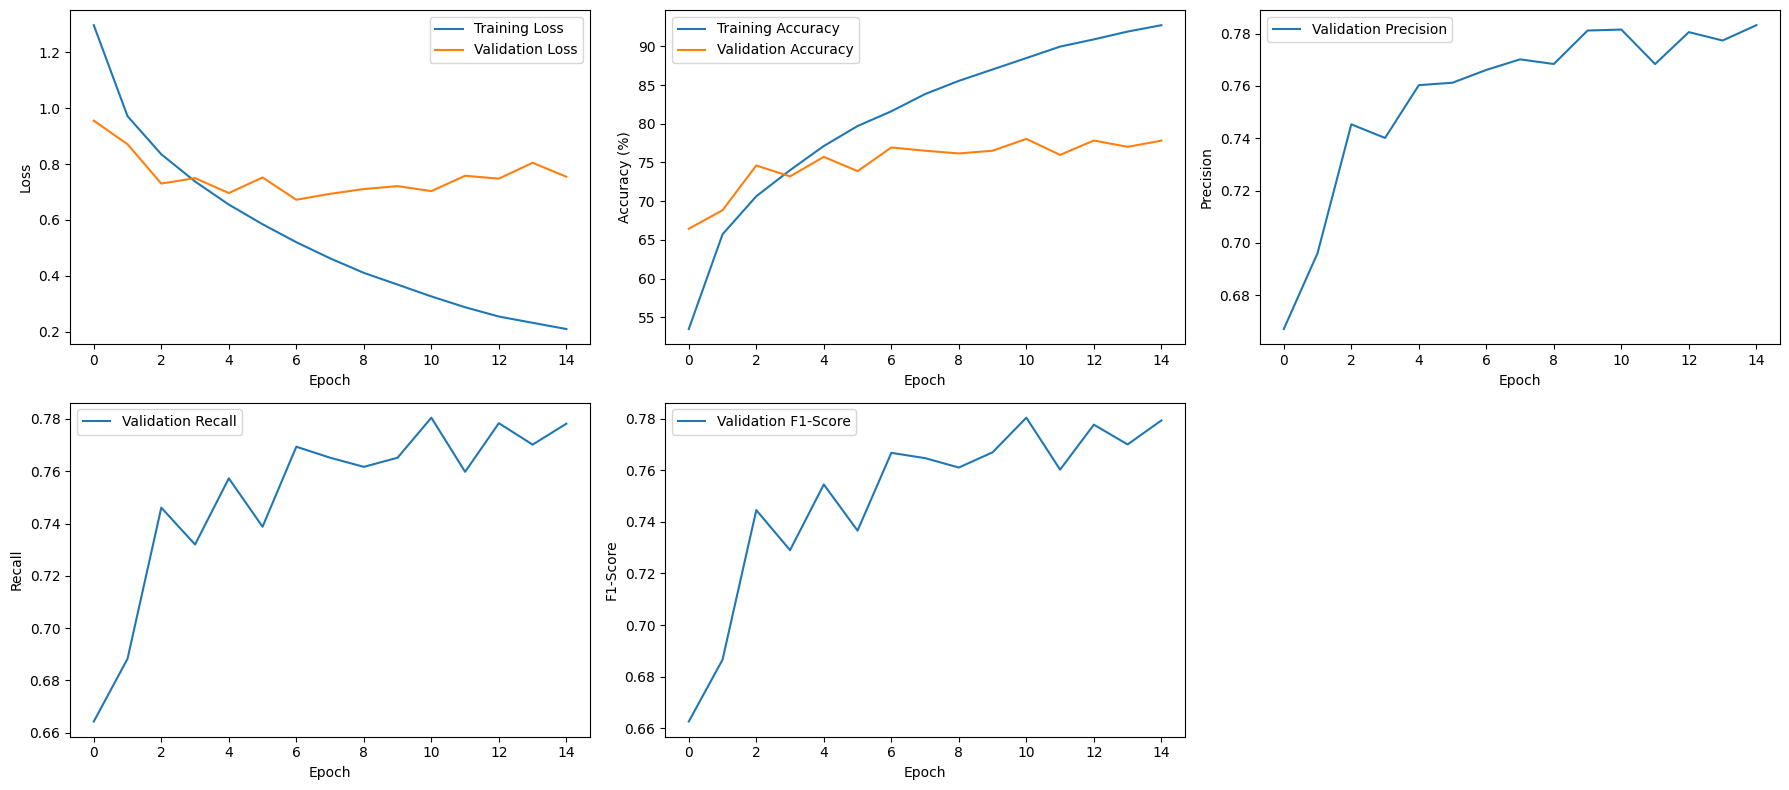

In [158]:
plot_history(history1)

In [ ]:
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Introduce evaluation function. test acc per class

In [159]:
def evaluate_model(model, data_loader, device="cuda"):
    model.eval()

    total_test = 0
    correct_test = 0

    all_labels = []
    all_predictions = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            all_outputs.extend(outputs.cpu().numpy())
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test

    # Calculate accuracy per class
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100

    # Print accuracy per class
    for i, acc in enumerate(class_accuracy):
        print(f'Accuracy for class {i}: {acc:.2f}%')

    print(f'Test Accuracy: {test_accuracy:.2f}%')


There's diversity between the classes as the accuracies ranges from 60 to 90

In [165]:
evaluate_model(model1, test_loader)

Accuracy for class 0: 79.40%
Accuracy for class 1: 85.10%
Accuracy for class 2: 67.50%
Accuracy for class 3: 60.30%
Accuracy for class 4: 80.30%
Accuracy for class 5: 72.40%
Accuracy for class 6: 76.60%
Accuracy for class 7: 80.50%
Accuracy for class 8: 90.10%
Accuracy for class 9: 85.40%
Test Accuracy: 77.76%


In [162]:
model2 = SimpleCNN()
model2.to(device)
optimizer2 = optim.Adam(model2.parameters())

In [163]:
history2 = train_and_validate(model2, train_loader, val_loader, optimizer2, criterion, num_epochs=EPOCHS, device="cuda")

Epoch 1/15, Training Loss: 1.2484, Training Accuracy: 55.92%, Validation Loss: 1.1993, Validation Accuracy: 59.88
Validation Precision: 0.6564, Validation Recall: 0.5988, Validation F1-Score: 0.5756


Epoch 2/15, Training Loss: 0.9123, Training Accuracy: 68.41%, Validation Loss: 0.7918, Validation Accuracy: 71.78
Validation Precision: 0.7241, Validation Recall: 0.7178, Validation F1-Score: 0.7179


Epoch 3/15, Training Loss: 0.7729, Training Accuracy: 72.95%, Validation Loss: 0.7210, Validation Accuracy: 74.36
Validation Precision: 0.7507, Validation Recall: 0.7436, Validation F1-Score: 0.7431


Epoch 4/15, Training Loss: 0.6761, Training Accuracy: 76.59%, Validation Loss: 0.7331, Validation Accuracy: 74.22
Validation Precision: 0.7436, Validation Recall: 0.7422, Validation F1-Score: 0.7365


Epoch 5/15, Training Loss: 0.5837, Training Accuracy: 79.70%, Validation Loss: 0.6274, Validation Accuracy: 77.87
Validation Precision: 0.7808, Validation Recall: 0.7787, Validation F1-Score: 0.7788


Epoch 6/15, Training Loss: 0.5029, Training Accuracy: 82.36%, Validation Loss: 0.6433, Validation Accuracy: 77.70
Validation Precision: 0.7761, Validation Recall: 0.7770, Validation F1-Score: 0.7735


Epoch 7/15, Training Loss: 0.4350, Training Accuracy: 84.84%, Validation Loss: 0.6758, Validation Accuracy: 76.90
Validation Precision: 0.7770, Validation Recall: 0.7690, Validation F1-Score: 0.7685


Epoch 8/15, Training Loss: 0.3756, Training Accuracy: 86.65%, Validation Loss: 0.7124, Validation Accuracy: 77.18
Validation Precision: 0.7765, Validation Recall: 0.7718, Validation F1-Score: 0.7690


Epoch 9/15, Training Loss: 0.3192, Training Accuracy: 88.94%, Validation Loss: 0.6918, Validation Accuracy: 77.96
Validation Precision: 0.7878, Validation Recall: 0.7796, Validation F1-Score: 0.7814


Epoch 10/15, Training Loss: 0.2753, Training Accuracy: 90.13%, Validation Loss: 0.6769, Validation Accuracy: 78.84
Validation Precision: 0.7901, Validation Recall: 0.7884, Validation F1-Score: 0.7869


Epoch 11/15, Training Loss: 0.2473, Training Accuracy: 91.16%, Validation Loss: 0.7239, Validation Accuracy: 78.14
Validation Precision: 0.7893, Validation Recall: 0.7814, Validation F1-Score: 0.7825


Epoch 12/15, Training Loss: 0.2102, Training Accuracy: 92.55%, Validation Loss: 0.7321, Validation Accuracy: 78.74
Validation Precision: 0.7916, Validation Recall: 0.7874, Validation F1-Score: 0.7878


Epoch 13/15, Training Loss: 0.1917, Training Accuracy: 93.27%, Validation Loss: 0.7281, Validation Accuracy: 78.88
Validation Precision: 0.7889, Validation Recall: 0.7888, Validation F1-Score: 0.7875


Epoch 14/15, Training Loss: 0.1751, Training Accuracy: 93.74%, Validation Loss: 0.7499, Validation Accuracy: 79.07
Validation Precision: 0.7963, Validation Recall: 0.7907, Validation F1-Score: 0.7914


Epoch 15/15, Training Loss: 0.1629, Training Accuracy: 94.27%, Validation Loss: 0.7773, Validation Accuracy: 78.56
Validation Precision: 0.7936, Validation Recall: 0.7856, Validation F1-Score: 0.7872


### The overfit increased xD but validation acc increased and the matrices slightly increased

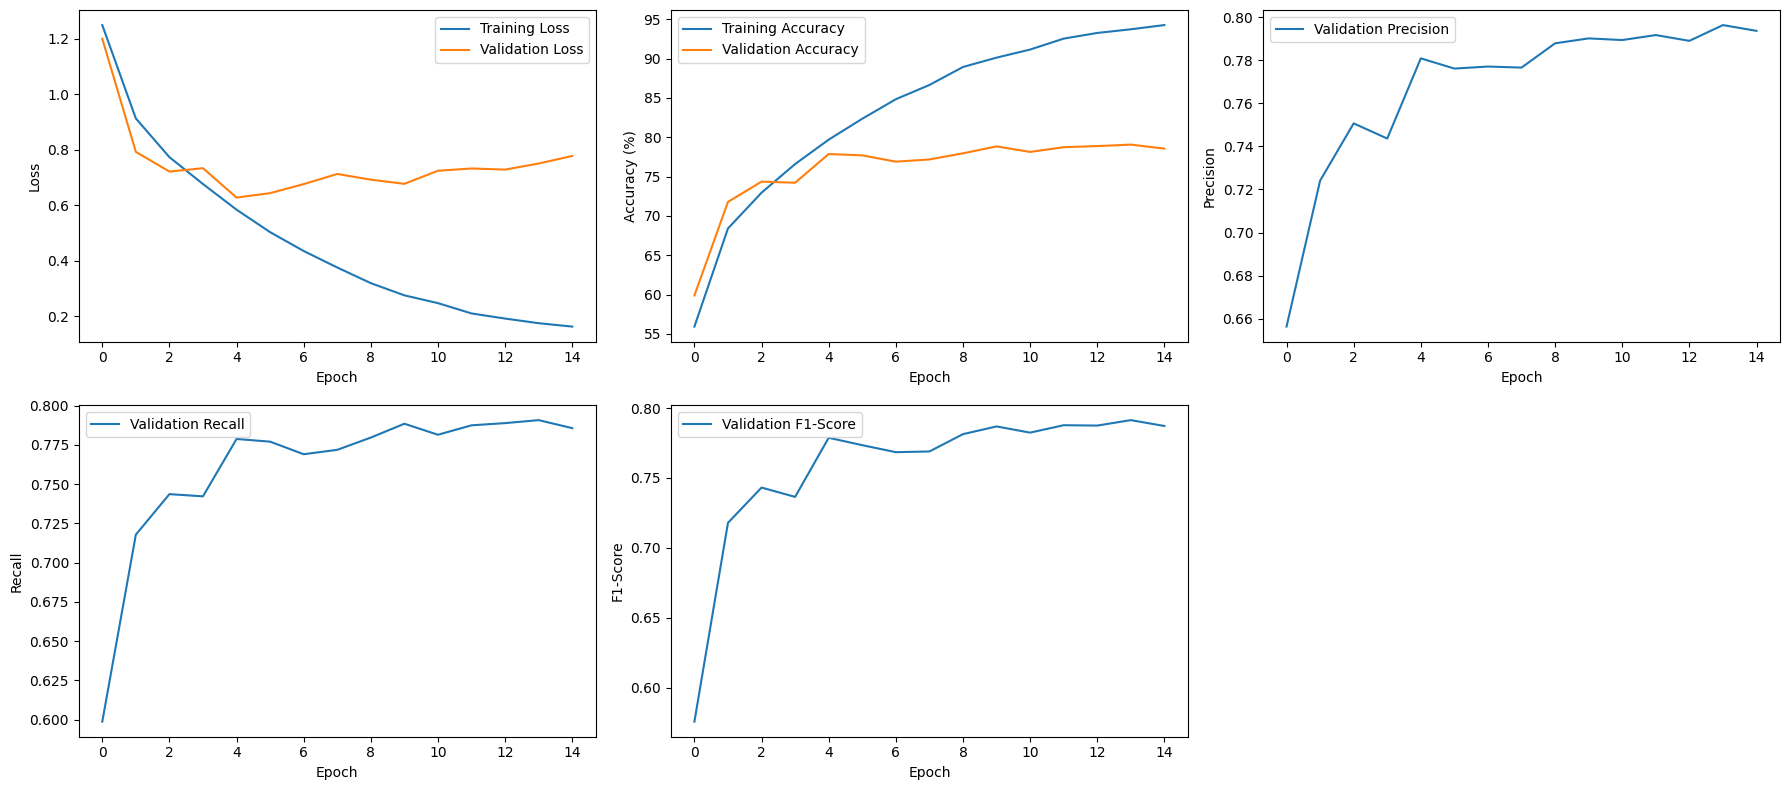

In [164]:
plot_history(history2)

### we need to do something to solve the overfitting problem

In [166]:
evaluate_model(model2, test_loader)

Accuracy for class 0: 78.50%
Accuracy for class 1: 90.50%
Accuracy for class 2: 76.30%
Accuracy for class 3: 56.70%
Accuracy for class 4: 70.40%
Accuracy for class 5: 78.90%
Accuracy for class 6: 81.50%
Accuracy for class 7: 82.30%
Accuracy for class 8: 81.80%
Accuracy for class 9: 83.40%
Test Accuracy: 78.03%


### Adding Dropout layers to handle overfitting problem 

In [180]:
class SimpleCNN(nn.Module):
    def __init__(self, first_dim=64):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, first_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(first_dim),  
            nn.ReLU(inplace=True),
            
            nn.Conv2d(first_dim, first_dim, kernel_size=3, padding=2),
            nn.BatchNorm2d(first_dim),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),


            nn.Conv2d(first_dim, first_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(first_dim*2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

        )
        self.classifier = nn.Sequential(
            nn.Linear(first_dim*2 * 8 * 8, first_dim*2),
            nn.BatchNorm1d(first_dim*2), 
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(first_dim*2, 10)  
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [181]:
model3 = SimpleCNN()
model3.to(device)
# same old optim as it returned better matrices
optimizer4 =  optim.Adam(model3.parameters())

In [183]:
history = train_and_validate(model3, train_loader, val_loader, optimizer4, criterion, num_epochs=EPOCHS, device="cuda")

Epoch 1/15, Training Loss: 1.3129, Training Accuracy: 53.68%, Validation Loss: 0.9831, Validation Accuracy: 64.59
Validation Precision: 0.6751, Validation Recall: 0.6459, Validation F1-Score: 0.6459


Epoch 2/15, Training Loss: 0.9891, Training Accuracy: 65.41%, Validation Loss: 0.8401, Validation Accuracy: 70.36
Validation Precision: 0.7144, Validation Recall: 0.7036, Validation F1-Score: 0.7025


Epoch 3/15, Training Loss: 0.8832, Training Accuracy: 69.18%, Validation Loss: 0.7809, Validation Accuracy: 72.60
Validation Precision: 0.7429, Validation Recall: 0.7260, Validation F1-Score: 0.7279


Epoch 4/15, Training Loss: 0.8026, Training Accuracy: 71.85%, Validation Loss: 0.7656, Validation Accuracy: 73.15
Validation Precision: 0.7493, Validation Recall: 0.7315, Validation F1-Score: 0.7338


Epoch 5/15, Training Loss: 0.7411, Training Accuracy: 74.02%, Validation Loss: 0.7040, Validation Accuracy: 74.89
Validation Precision: 0.7554, Validation Recall: 0.7489, Validation F1-Score: 0.7468


Epoch 6/15, Training Loss: 0.6934, Training Accuracy: 75.72%, Validation Loss: 0.6556, Validation Accuracy: 76.87
Validation Precision: 0.7713, Validation Recall: 0.7687, Validation F1-Score: 0.7672


Epoch 7/15, Training Loss: 0.6479, Training Accuracy: 77.18%, Validation Loss: 0.6235, Validation Accuracy: 77.86
Validation Precision: 0.7805, Validation Recall: 0.7786, Validation F1-Score: 0.7768


Epoch 8/15, Training Loss: 0.6122, Training Accuracy: 78.37%, Validation Loss: 0.6502, Validation Accuracy: 77.43
Validation Precision: 0.7793, Validation Recall: 0.7743, Validation F1-Score: 0.7720


Epoch 9/15, Training Loss: 0.5706, Training Accuracy: 79.86%, Validation Loss: 0.6186, Validation Accuracy: 77.99
Validation Precision: 0.7877, Validation Recall: 0.7799, Validation F1-Score: 0.7789


Epoch 10/15, Training Loss: 0.5393, Training Accuracy: 81.00%, Validation Loss: 0.6289, Validation Accuracy: 78.33
Validation Precision: 0.7908, Validation Recall: 0.7833, Validation F1-Score: 0.7823


Epoch 11/15, Training Loss: 0.5054, Training Accuracy: 82.22%, Validation Loss: 0.6060, Validation Accuracy: 78.88
Validation Precision: 0.7927, Validation Recall: 0.7888, Validation F1-Score: 0.7869


Epoch 12/15, Training Loss: 0.4859, Training Accuracy: 82.79%, Validation Loss: 0.5865, Validation Accuracy: 79.34
Validation Precision: 0.7985, Validation Recall: 0.7934, Validation F1-Score: 0.7928


Epoch 13/15, Training Loss: 0.4614, Training Accuracy: 83.70%, Validation Loss: 0.6242, Validation Accuracy: 78.84
Validation Precision: 0.7951, Validation Recall: 0.7884, Validation F1-Score: 0.7864


Epoch 14/15, Training Loss: 0.4426, Training Accuracy: 84.41%, Validation Loss: 0.5855, Validation Accuracy: 79.76
Validation Precision: 0.8001, Validation Recall: 0.7976, Validation F1-Score: 0.7952


Epoch 15/15, Training Loss: 0.4190, Training Accuracy: 85.17%, Validation Loss: 0.5623, Validation Accuracy: 80.51
Validation Precision: 0.8066, Validation Recall: 0.8051, Validation F1-Score: 0.8046


Now 7/10 classes have accuracy higher than 80 and only one class lower than 70. better resutls

In [184]:
evaluate_model(model3, test_loader)

Accuracy for class 0: 80.30%
Accuracy for class 1: 85.80%
Accuracy for class 2: 72.30%
Accuracy for class 3: 61.30%
Accuracy for class 4: 82.80%
Accuracy for class 5: 72.30%
Accuracy for class 6: 88.60%
Accuracy for class 7: 81.60%
Accuracy for class 8: 91.20%
Accuracy for class 9: 88.00%
Test Accuracy: 80.42%


Now the model is more generalized and have no overfit

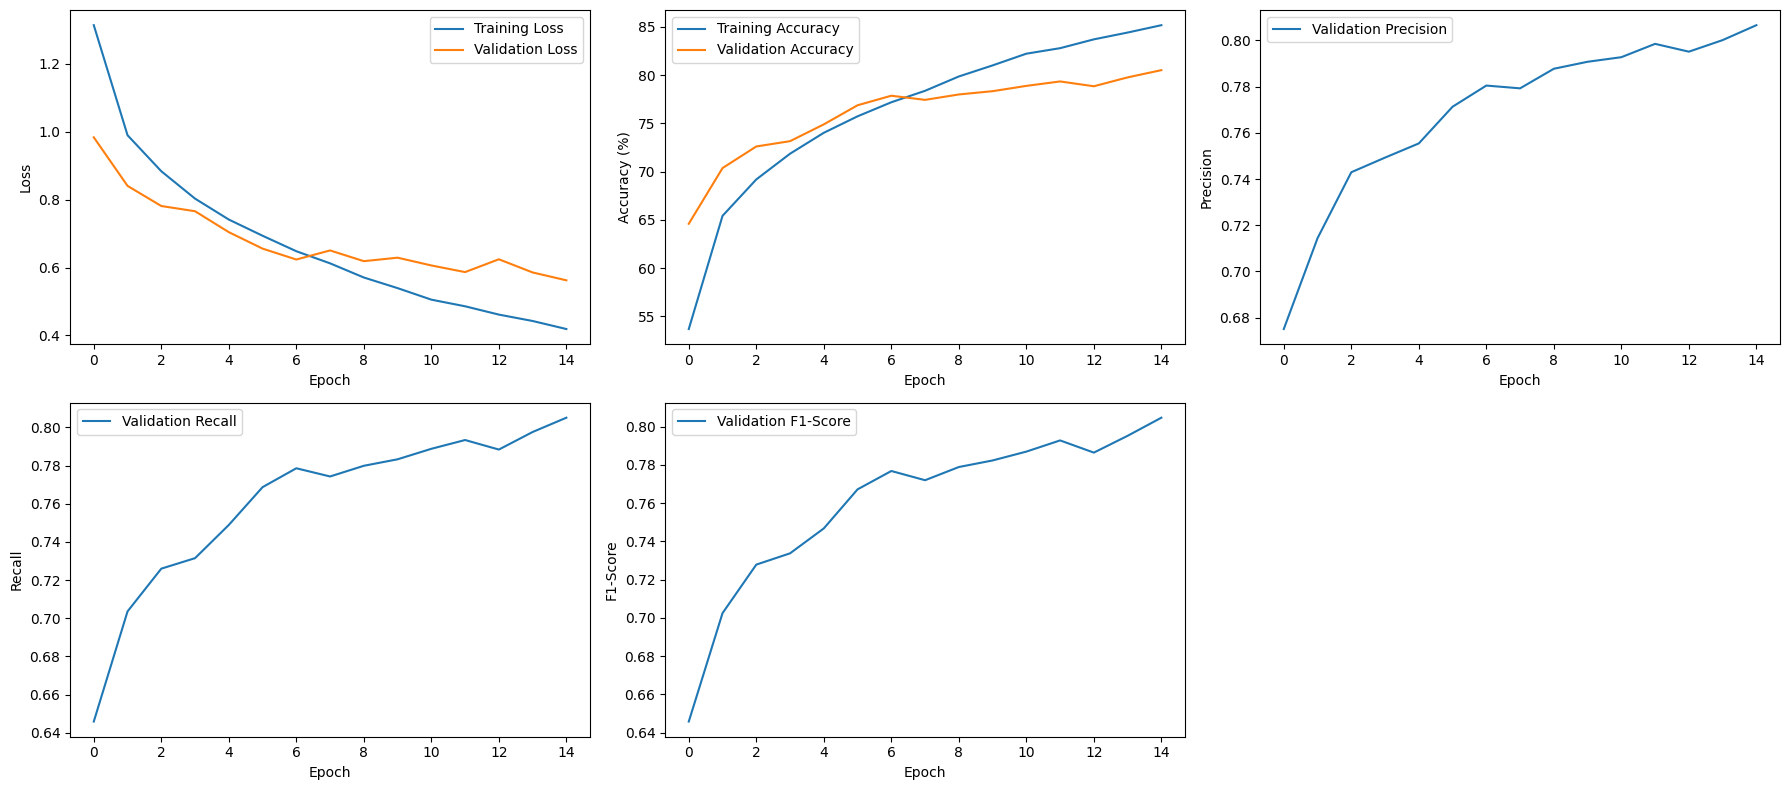

In [185]:
plot_history(history)

### Suggestions to improve the results:
- Increase the number of nodes in the arch.
- Change data augmentation.
- Transfer learning.
- Try different arch.